In [1]:
import importlib
import argparse
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
import torch
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler
from torch.autograd import Variable
from torchvision import transforms

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


%matplotlib inline

In [4]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

In [5]:
#Define parser
#name = 'bpi_2012'
name = 'bpi_2013'
#name = 'Road_Traffic_Fine_Management_Process'  

parser = {
    'train': True,
    'test': True,
    'model_class': 'AE',
    'model_name': '',
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'anomaly_pct': 0.1,
    'input_dir': '../input/{}/'.format(name), 
    'output_dir': './output/{}/'.format(name),
    'batch_size' : 16,
    'epochs' : 10,
    'no_cuda' : False,
    'seed' : 7,
    'layer1': 1000,
    'layer2': 100,
    'lr': 0.002,
    'betas': (0.9, 0.999),   
    'lr_decay': 0.90,
}

args = argparse.Namespace(**parser)

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

In [8]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [9]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_val = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_val = pickle.load(f)
    time_label_test = pickle.load(f)
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    cols = pickle.load(f)

# Load data

In [10]:
#train
input_trainLoader = torch.utils.data.DataLoader(input_train, batch_size=args.batch_size, shuffle=False, num_workers=2)
pad_index_trainLoader = torch.utils.data.DataLoader(pad_index_train, batch_size=args.batch_size, shuffle=False, num_workers=2)

# Build model

## Define model

In [11]:
if args.model_class == 'AE':
    model = AE(input_train.shape, args.layer1, args.layer2)

if args.cuda:
    model.cuda()

## Define loss

In [12]:
def loss_function(recon_x, x, pad_index):
    #MSE = F.mse_loss(recon_x, x, weight=pad_index, size_average=False) 
    BCE = F.binary_cross_entropy(recon_x, x, weight=pad_index, size_average=False)
    return BCE

## Define optimizer

In [13]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)

In [14]:
#Adjust learning rate per epoch: http://pytorch.org/docs/master/optim.html?highlight=adam#torch.optim.Adam

# Method 1:
lambda1 = lambda epoch: args.lr_decay ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

# Method 2:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

# Utils

In [15]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.output_dir, 'model_{}_epoch{}_score{:.4f}.pth'.format(args.model_class, epoch, score))
    torch.save(model.state_dict(), model_file)

In [16]:
def load_model(model, model_name):
    model_file = os.path.join(args.output_dir, model_name)
    assert os.path.isfile(model_file), 'Error: no model found!'
    model_state = torch.load(model_file)
    model.load_state_dict(model_state)

In [17]:
def val(model, input_val, pad_index_val):
    model.eval()
    input_val = Variable(torch.Tensor(input_val).float())
    pad_index_val = Variable(torch.Tensor(pad_index_val).float())
    
    if args.cuda:
        input_val = input_val.cuda()
        pad_index_val = pad_index_val.cuda()
    
    recon_val = model(input_val)    
    loss = loss_function(recon_val, input_val, pad_index_val)
    return loss.data[0]/len(input_test.data)

# Train

In [18]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (batch_data, batch_index) in enumerate(zip(input_trainLoader, pad_index_trainLoader)):
        
        batch_data = Variable(batch_data.float())
        batch_index = Variable(batch_index.float())

        if args.cuda:
            batch_data = batch_data.cuda()
            batch_index = batch_index.cuda()
            
        optimizer.zero_grad()
        
        recon_data = model(batch_data)
        
        loss = loss_function(recon_data, batch_data, batch_index)
        
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        
    return train_loss / len(input_trainLoader.dataset)

In [19]:
if args.train:
    for epoch in range(1, args.epochs + 1):
        init = time.time()
        
        #method 1 scheduler
        scheduler.step()
        train_loss = train(epoch, model, optimizer)
        val_score = val(model, input_val, pad_index_val)
        
        #if epoch == 1:
        #    current_best = val_score
        #    save_model(model, epoch, val_score)
        
        #else:
        #    if val_score < current_best:
        #        current_best = val_score
        #        save_model(model, epoch, val_score)
        
        #method 2 scheduler
        #scheduler.step()
        
        end = time.time()
        print('====> Epoch {} | Time: {} ms| Train loss: {:.4f} | Val loss: {:.4f}'.format(
                          epoch, (end-init)*1000 ,train_loss, val_score))
else:
    load_model(model, args.model_name)

====> Epoch 1 | Time: 907.149076461792 ms| Train loss: 7.7299 | Val loss: 2.9808
====> Epoch 2 | Time: 773.7109661102295 ms| Train loss: 4.2419 | Val loss: 1.9611
====> Epoch 3 | Time: 746.0410594940186 ms| Train loss: 2.8432 | Val loss: 1.5334
====> Epoch 4 | Time: 760.7429027557373 ms| Train loss: 2.0686 | Val loss: 1.3438
====> Epoch 5 | Time: 913.7730598449707 ms| Train loss: 1.5954 | Val loss: 1.1970
====> Epoch 6 | Time: 886.7671489715576 ms| Train loss: 1.2595 | Val loss: 1.1010
====> Epoch 7 | Time: 840.479850769043 ms| Train loss: 1.0392 | Val loss: 1.0604
====> Epoch 8 | Time: 784.4460010528564 ms| Train loss: 0.9006 | Val loss: 1.0703
====> Epoch 9 | Time: 770.4410552978516 ms| Train loss: 0.8098 | Val loss: 1.0660
====> Epoch 10 | Time: 760.9279155731201 ms| Train loss: 0.7445 | Val loss: 1.0680


# Predict

In [20]:
if args.test:
    input_test = Variable(torch.Tensor(input_test).float())
    if args.cuda:
        input_test = input_test.cuda()
    
    print('Predicting...')
    recon_test = model(input_test)
    
    print('Separating error for time and activity...')
    predicted_time, predicted_activity, true_time, true_activity = getError(recon_test, input_test, pad_index_test)
    
    print('Done!')

Predicting...
Separating error for time and activity...
Done!


# Evaluate

In [21]:
def plotConfusionMaxtrix(error_df, threshold, variable='Activity'):
    LABELS = ['Normal', 'Anomaly']
    y_pred = [1 if e > threshold else 0 for e in error_df.Error.values]
    
    if variable == 'Activity':
        matrix = confusion_matrix(error_df.ActivityLabel, y_pred)
    else:
        matrix = confusion_matrix(error_df.TimeLabel, y_pred)
        
    plt.figure(figsize=(7, 7))
    sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title('Confusion matrix of {}'.format(variable))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [42]:
def eval(error_df, threshold, variable='Activity'):
    y_pred = [1 if e > threshold else 0 for e in error_df.Error.values]
    
    if variable=='Activity':
        y_true = error_df.ActivityLabel
    else:
        y_true = error_df.TimeLabel
    
    score = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        
    print('Evaluation of {}'.format(variable))
    print('Precision: {:.2f}'.format(score[0]))
    print('Recall: {:.2f}'.format(score[1]))
    print('Fscore: {:.2f}'.format(score[2]))
    #print('Support: {:.2f}'.format(score[3]))

## Time

In [22]:
np.mean(np.power(true_time - predicted_time, 2))

0.00012426063472154798

In [23]:
error = np.abs(true_time - predicted_time)
error_time_df = pd.DataFrame({'Error': error,
                              'TimeLabel': time_label_test})

In [24]:
error_time_df.head()

,Error,TimeLabel
5589,0.008976,1
5590,0.003715,0
5591,0.008946,0
5592,0.001842,0
5593,0.009038,0


In [25]:
time_threshold = np.mean(error_time_df['Error'])
print('Threshold of Time: {}'.format(time_threshold))

Threshold of Time: 0.00783563115883218


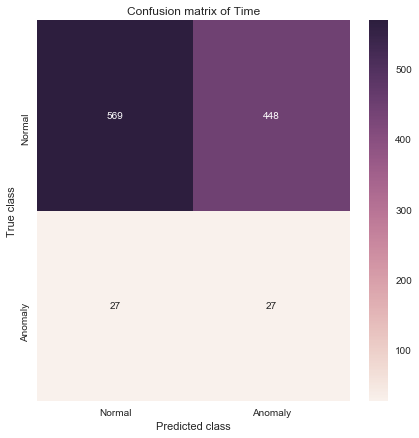

In [26]:
plotConfusionMaxtrix(error_time_df, time_threshold, variable='Time')

In [43]:
eval(error_time_df, time_threshold, variable='Time')

Evaluation of Time
Precision: 0.91
Recall: 0.56
Fscore: 0.68


## Activity

In [27]:
error = np.mean(np.power(true_activity - predicted_activity, 2), axis = 1)
error_activity_df = pd.DataFrame({'Error': error,
                                  'ActivityLabel': activity_label_test})

In [28]:
error_activity_df.head()

,ActivityLabel,Error
5589,0,0.078941
5590,0,0.078940
5591,0,0.078941
5592,0,0.078940
5593,0,0.078941


In [29]:
activity_threshold = np.mean(error_activity_df['Error'])
print('Threshold of Activity: {}'.format(activity_threshold))

Threshold of Activity: 0.08120570671622163


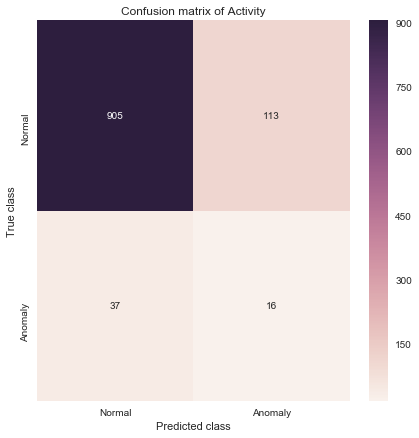

In [30]:
plotConfusionMaxtrix(error_activity_df, activity_threshold, variable='Activity')

In [44]:
eval(error_activity_df, activity_threshold, variable='Activity')

Evaluation of Activity
Precision: 0.92
Recall: 0.86
Fscore: 0.89
